<a href="https://colab.research.google.com/github/Zubair-hussain/Fake-News-Detection-using-NLP/blob/main/Fake_News_Detection_using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Description**

# Fake News Detection using NLP & Machine Learning

**Objective**: Build a Fake News Classifier using Natural Language Processing (NLP) and Machine Learning.

Dataset: [Fake and Real News Dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)  



In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [4]:


dataset_dir = path  # or manually set if known

fake_df = pd.read_csv(os.path.join(dataset_dir, "Fake.csv"))
real_df = pd.read_csv(os.path.join(dataset_dir, "True.csv"))

fake_df['label'] = 0  # 0 = Fake
real_df['label'] = 1  # 1 = Real

df = pd.concat([fake_df, real_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

df

,title,text,subject,date,label
0,Outgoing GOP Senator BLISTERS The ‘Adult Dayc...,Senator Bob Corker (R-TN) has had enough of th...,News,"October 8, 2017",0
1,Potential New Hampshire spoiler Kasich could p...,"MANCHESTER, N.H. (Reuters) - U.S. Republican p...",politicsNews,"February 8, 2016",1
2,Third Grader ROASTS Trump With Hilarious Lett...,Since the start of Donald Trump s presidential...,News,"January 22, 2016",0
3,Pope arrives in Colombia on mission to promote...,BOGOTA (Reuters) - Pope Francis arrived on a f...,worldnews,"September 6, 2017",1
4,Former U.S. President Jimmy Carter says would ...,NEW YORK (Reuters) - Former U.S. President Jim...,politicsNews,"October 22, 2017",1
...,...,...,...,...,...
44893,"NZ First touts progress in talks to form govt,...",WELLINGTON (Reuters) - The leader of the small...,worldnews,"October 10, 2017",1
44894,Turkey did not violate U.S. sanctions against ...,ANKARA (Reuters) - Turkey did not violate U.S....,worldnews,"November 30, 2017",1
44895,"After Trump Attacks Family Of Fallen Soldier,...",The mother at the center of Donald Trump s att...,News,"July 30, 2016",0
44896,Watch The Moment The Daily Show Realized Trum...,"Election night on November 8, took everyone by...",News,"November 9, 2016",0


# **Preprocess the Text Data**

In [5]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = "".join([ch for ch in text if ch not in string.punctuation])  # Remove punctuation
    tokens = text.split()  # Simple tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return " ".join(tokens)

# Apply cleaning to the text column
df['text_clean'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# **Exploratory Data Analysis (EDA)**

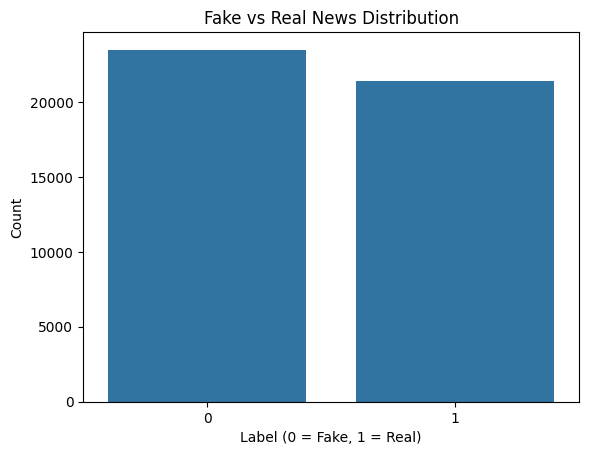

In [6]:
sns.countplot(x='label', data=df)
plt.title('Fake vs Real News Distribution')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

## **Article Length Distribution**

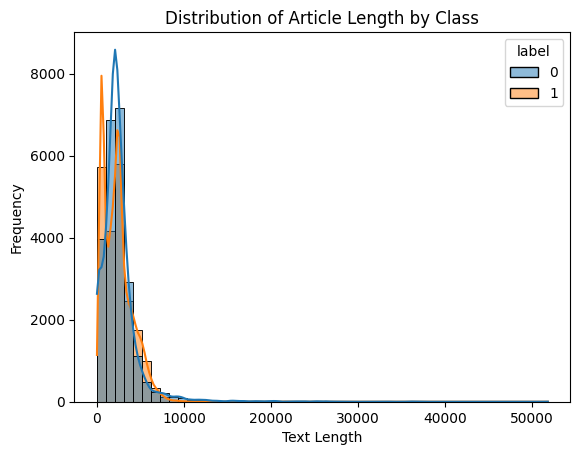

In [7]:
df['text_length'] = df['text'].apply(len)

sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Article Length by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


 **Word Cloud (Optional but Insightful) **



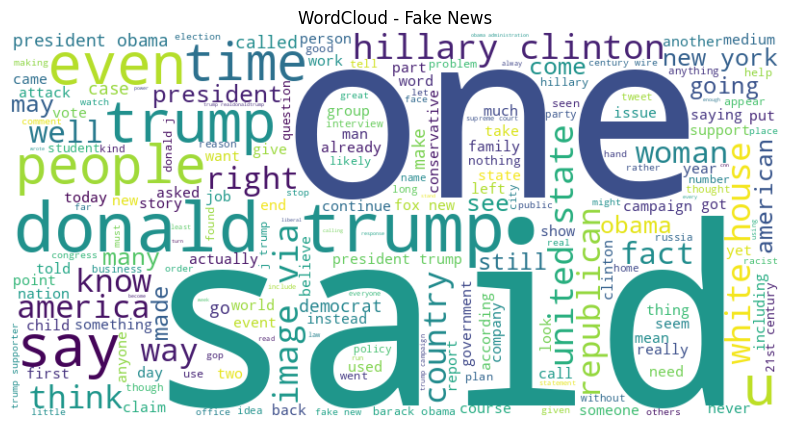

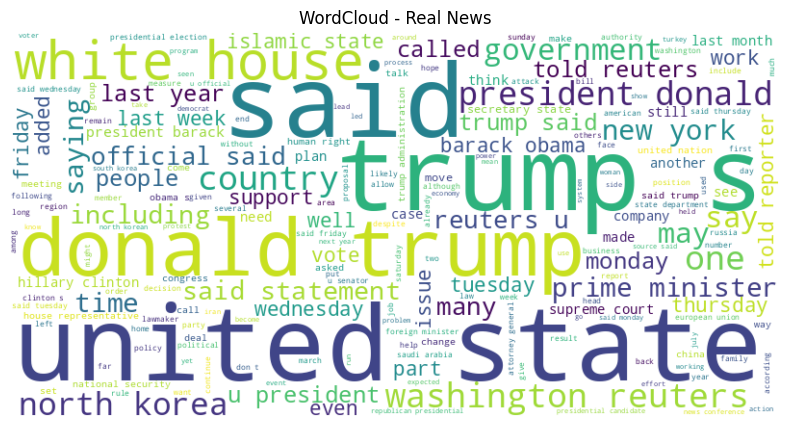

In [8]:
# WordCloud for FAKE news
fake_text = " ".join(df[df['label'] == 0]['text_clean'])
fake_wc = WordCloud(width=800, height=400, background_color='white').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Fake News")
plt.show()

# WordCloud for REAL news
real_text = " ".join(df[df['label'] == 1]['text_clean'])
real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud - Real News")
plt.show()

# **Feature Engineering using TF-IDF**

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  # Reduce for speed
X = vectorizer.fit_transform(df['text_clean']).toarray()
y = df['label']



X → contains numerical features (TF-IDF vectors)

y → contains labels (0 = Fake, 1 = Real)




# **Train/Test Split**

Perform the Split

In [10]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Output:
X_train, y_train → training data

X_test, y_test → test data

# **Model Training**

Train the **Models**

In [11]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)


MultinomialNB()

:

# **Model Evaluation**

Define a Reusable Evaluation Function

In [12]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Results for {model_name}")
    print("-" * 50)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# **Define Reusable Evaluation Function**

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(y_true, y_pred, model_name):
    print(f" Results for {model_name}")
    print("-" * 50)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# **Evaluate Naive Bayes with the Function**

 Results for Naive Bayes
--------------------------------------------------
Accuracy: 0.9354120267260579

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      4640
           1       0.92      0.94      0.93      4340

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



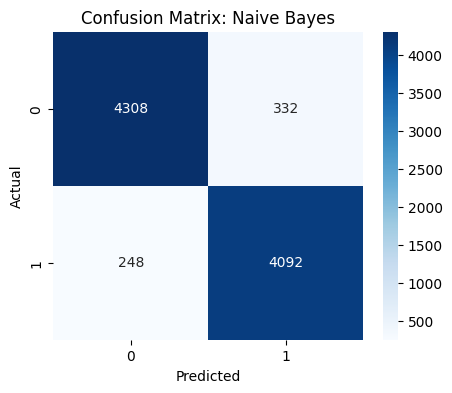

In [14]:
#  Train & Evaluate Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
evaluate_model(y_test, y_pred_nb, "Naive Bayes")


 Results for Logistic Regression
--------------------------------------------------
Accuracy: 0.9859688195991091

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4640
           1       0.98      0.99      0.99      4340

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



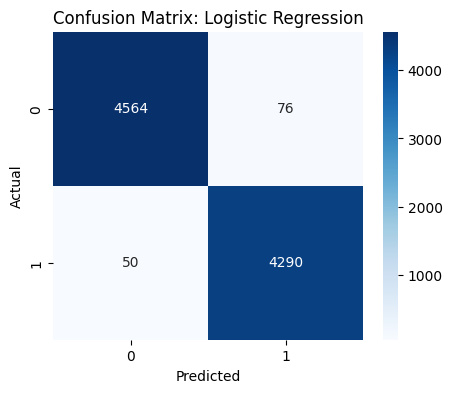

In [15]:
#  Train & Evaluate Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
evaluate_model(y_test, lr_model.predict(X_test), "Logistic Regression")


 Results for Linear SVM
--------------------------------------------------
Accuracy: 0.9923162583518931

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4640
           1       0.99      0.99      0.99      4340

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



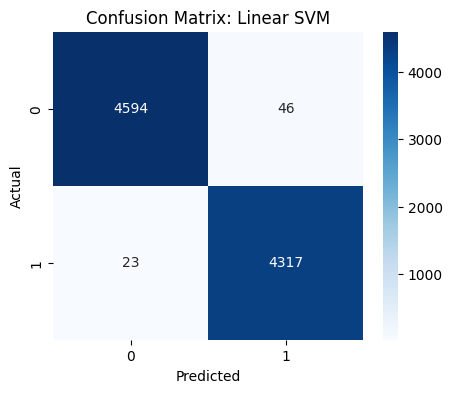

In [16]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
evaluate_model(y_test, svm_model.predict(X_test), "Linear SVM")


# **Streamlit Integration**

 Results for Linear SVM
--------------------------------------------------
Accuracy: 0.9923162583518931

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4640
           1       0.99      0.99      0.99      4340

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



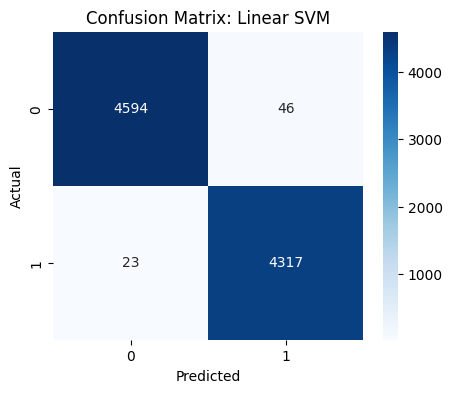

In [17]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
evaluate_model(y_test, svm_model.predict(X_test), "Linear SVM")


# **Save Trained Model & Vectorizer**

In [20]:
import pickle

# Save the best model (Logistic Regression or whichever you choose)
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

# Save the TF-IDF vectorizer (you named it 'vectorizer')
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully.")


Model and vectorizer saved successfully.


In [22]:
from google.colab import files

# Download model
files.download("logistic_model.pkl")

# Download vectorizer
files.download("tfidf_vectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  Fake News Classification using NLP

##  Project Overview
This project detects fake vs. real news using natural language processing (NLP) and classical machine learning models. The dataset includes 40,000+ articles labeled as `FAKE` or `REAL`.

##  Dataset
- Source: [Kaggle - Fake and Real News Dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset)
- Fields: `title`, `text`, `subject`, `date`

##  Techniques Used
- Text Cleaning (lowercase, punctuation, stopword removal, lemmatization)
- TF-IDF Vectorization
- Models: Logistic Regression, Naive Bayes, Support Vector Machine (SVM)
- Evaluation: Accuracy, F1-Score, Precision, Recall, Confusion Matrix

#Results
| Model               | Accuracy         |
|--------------------|------------------|
| Naive Bayes        | 93.71%           |
| Logistic Regression| 98.74%           |
| Linear SVM         | 99.31%  Best   |

###  Results for Naive Bayes
--------------------------------------------------
- Accuracy: 93.71%
- Pros: Fast training, simple model
- Suitable for: Low-resource environments

###  Results for Logistic Regression
--------------------------------------------------
- Accuracy: 98.74%
- Pros: High accuracy, interpretable, efficient
- Suitable for: Balanced performance and speed

###  Results for Linear SVM
--------------------------------------------------
- Accuracy: 99.31%
- Pros: Best performance, robust to high-dimensional data
- Cons: Slightly slower to train than NB/LR
- Suitable for: Production-grade classification



##  Bonus
Deploy a Streamlit app to classify user-inputted articles.





##  Learning Outcomes
- Practical NLP experience
- Vectorization and ML modeling
- Model evaluation and interpretation
